### ARIMA Model

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from utils import get_apple_close_price, plot_series, plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import train_test_split, ARIMA_walk_forward_validation, get_range

In [2]:
apple_close_price = get_apple_close_price()

In [3]:
short_series = get_range(apple_close_price, '2003-01-01')

In [4]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast

In [5]:
train, test= train_test_split(short_series,'2018-05-31')

We need to first find out the best parameters for ARIMA(p, d, q). Let's do a grid search:

In [6]:
import warnings
warnings.simplefilter('ignore')

In [7]:
best_aic = np.inf 
best_order = None

p = look_back # we fix the autoregressive p param (lags) to look back window
d_range = range(2) # [0, 1]
q_range = range(3) # [0, 1, 2]

for d in d_range:
    for q in q_range:
        try:
            order = (p, d, q)
            tmp_model = ARIMA(train, order=order).fit(disp=0)
            tmp_aic = tmp_model.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = order
                best_model = tmp_model
                print('best aic: {:6.2f} | order: {}'.format(best_aic, best_order))
        except: continue


print('Final aic: {:6.2f} | order: {}'.format(best_aic, best_order))

best aic: 11921.62 | order: (5, 0, 0)
best aic: 11902.81 | order: (5, 1, 0)
best aic: 11902.09 | order: (5, 1, 1)
best aic: 11884.66 | order: (5, 1, 2)
Final aic: 11884.66 | order: (5, 1, 2)


I found this [library](http://www.alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html), Auto ARIMA, which automatically discover the optimal order for an ARIMA model. Let's double check with it our finding

In [9]:
from pyramid.arima import auto_arima

In [10]:
auto_arima_test = auto_arima(train, d=1, 
                             start_p=look_back, max_p=look_back, 
                             start_q=0, max_q=2, 
                             seasonal=False, 
                             trace=True, 
                             error_action='ignore', 
                             suppress_warnings=True, 
                             stepwise=False)

print('aic: {:6.2f} | order: {}'.format(auto_arima_test.aic(), auto_arima_test.order))

Fit ARIMA: order=(5, 1, 0); AIC=11902.812, BIC=11946.656, Fit time=0.272 seconds
Fit ARIMA: order=(5, 1, 1); AIC=11902.091, BIC=11952.198, Fit time=3.633 seconds
Fit ARIMA: order=(5, 1, 2); AIC=11884.660, BIC=11941.030, Fit time=4.355 seconds
Total fit time: 8.263 seconds
aic: 11884.66 | order: (5, 1, 2)


As we can see, it comes to the same conclusion, order=(5, 1, 2)

In [11]:
order = best_order
ARIMAmodel = ARIMA(train, order=order)

In [12]:
ARIMAmodel_fit = ARIMAmodel.fit(disp=0)

In [13]:
print(ARIMAmodel_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3879
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -5933.330
Method:                       css-mle   S.D. of innovations              1.117
Date:                Thu, 11 Jul 2019   AIC                          11884.660
Time:                        09:23:46   BIC                          11941.030
Sample:                             1   HQIC                         11904.673
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0479      0.018      2.621      0.009       0.012       0.084
ar.L1.D.Close    -0.6192      0.050    -12.347      0.000      -0.717      -0.521
ar.L2.D.Close    -0.8686      0.043    -

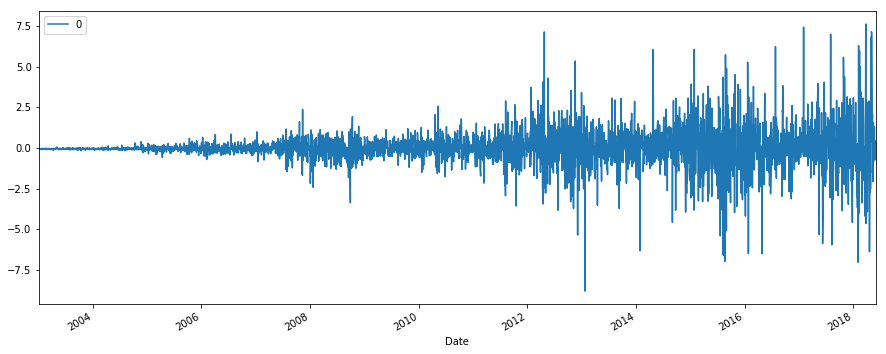

In [14]:
residuals = pd.DataFrame(ARIMAmodel_fit.resid)
residuals.plot(figsize=(15, 6))

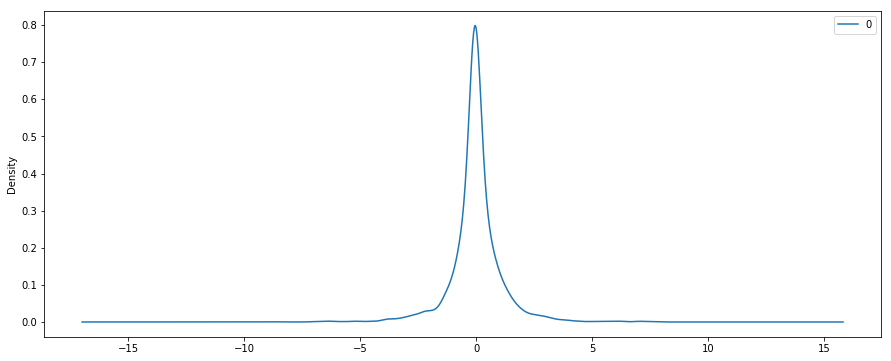

In [15]:
residuals.plot(kind='kde', figsize=(15, 6))

In [16]:
residuals.describe()

,0
count,3.879000e+03
mean,-8.325975e-07
std,1.117151e+00
min,-8.786566e+00
25%,-3.275605e-01
50%,-3.462908e-02
75%,3.368815e-01
max,7.624666e+00


In [17]:
size = 252 # approx. one year
steps = n_outputs
predictions = ARIMA_walk_forward_validation(train, 
                                            test, 
                                            order, 
                                            size=size, 
                                            steps=steps)

predicted=[186.64691247 186.81083226 187.02772388 186.87478589 186.91926057], expected=[190.240005 191.830002 193.309998 193.979996 193.460007]
predicted=[193.45109276 193.46773292 193.67260487 193.57504345 193.65134847], expected=[191.699997 191.229996 192.279999 190.699997 190.800003]
predicted=[190.91376522 191.06662287 190.96168378 191.06422762 191.2113359 ], expected=[188.839996 188.740005 185.690002 186.5      185.460007]
predicted=[185.45997805 185.42679605 185.50960917 185.56204098 185.53583612], expected=[184.919998 182.169998 184.429993 184.160004 185.5     ]
predicted=[185.66385901 185.84446082 185.66376516 185.76506538 185.93714379], expected=[185.110001 187.179993 183.919998 185.399994 187.970001]
predicted=[188.0627613  187.87670704 188.18084842 188.24819858 187.98983724], expected=[190.580002 190.350006 187.880005 191.029999 191.330002]
predicted=[191.45050935 191.53914089 191.60599161 191.52367985 191.63447315], expected=[190.910004 191.449997 190.399994 191.880005 191.

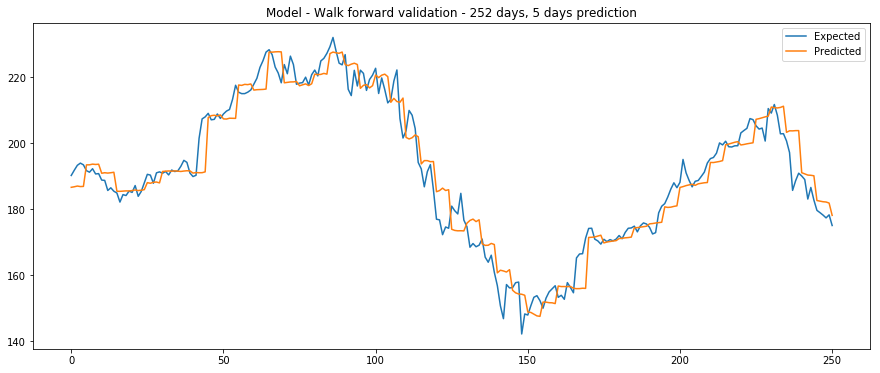

In [18]:
plot_walk_forward_validation(np.array(test), predictions, size=size, steps=steps)

Let's plot the [Residual Forecast Error](https://en.wikipedia.org/wiki/Forecast_error). This is calculated as the expected value minus the predicted value.

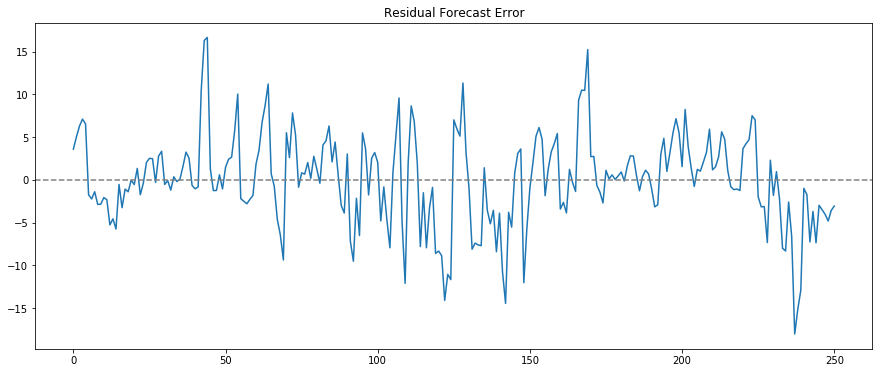

In [19]:
plot_residual_forecast_error(predictions, test[:size])

In [20]:
print_performance_metrics(predictions, 
                          test[:size], 
                          model_name='ARIMA', 
                          total_days=size, 
                          steps=steps)

ARIMA[252 days, 5 days forecast]:

Forecast Bias: -0.040
MAE: 4.039
MSE: 28.784
RMSE: 5.365
MAPE: 2.147
